In [10]:
import os
from itertools import product

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Download data

In [11]:
if not os.path.isdir('data'):
    os.mkdir('data')
    !kaggle competitions download -c playground-series-s5e11
    !unzip playground-series-s5e11.zip -d data
    !kaggle datasets download nabihazahid/loan-prediction-dataset-2025
    !unzip loan-prediction-dataset-2025.zip -d data
    !rm playground-series-s5e11.zip
    !rm loan-prediction-dataset-2025.zip

In [12]:
import sgpp

import polars as pl
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.metrics import roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import shap

In [14]:
!head data/train.csv

id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.1,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.2,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.1,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.7,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0
5,44940.3,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.0
6,61574.16,0.042,696,16907.71,13.52,Other,Single,High School,Self-employed,Debt consolidation,C5,1.0
7,45953.31,0.1,654,10111.62,12.82,Female,Married,High School,Employed,Home,D1,1.0
8,30592.29,0.132,713,7522.36,9.48,Male,Married,Bachelor's,Employed,Education,C5,1.0


# Read data

In [15]:
p = make_pipeline(
    sgpp.PolarsProcessor(predefined_types={'id': pl.Int64}),
    sgpp.ExprProcessor({
        'loan_paid_back': pl.col('loan_paid_back').cast(pl.Int8)
    }),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform('data/train.csv')
df_test = p.transform('data/test.csv')
df_org = p.transform('data/loan_dataset_20000.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         593994 non-null  float32 
 1   debt_to_income_ratio  593994 non-null  float32 
 2   credit_score          593994 non-null  int16   
 3   loan_amount           593994 non-null  float32 
 4   interest_rate         593994 non-null  float32 
 5   gender                593994 non-null  category
 6   marital_status        593994 non-null  category
 7   education_level       593994 non-null  category
 8   employment_status     593994 non-null  category
 9   loan_purpose          593994 non-null  category
 10  grade_subgrade        593994 non-null  category
 11  loan_paid_back        593994 non-null  int8    
dtypes: category(6), float32(4), int16(1), int8(1)
memory usage: 18.7 MB


In [8]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   20000 non-null  int64   
 1   gender                20000 non-null  category
 2   marital_status        20000 non-null  category
 3   education_level       20000 non-null  category
 4   annual_income         20000 non-null  float32 
 5   monthly_income        20000 non-null  float64 
 6   employment_status     20000 non-null  category
 7   debt_to_income_ratio  20000 non-null  float32 
 8   credit_score          20000 non-null  int16   
 9   loan_amount           20000 non-null  float32 
 10  loan_purpose          20000 non-null  category
 11  interest_rate         20000 non-null  float32 
 12  loan_term             20000 non-null  int64   
 13  installment           20000 non-null  float64 
 14  grade_subgrade        20000 non-null  category
 15  nu

In [9]:
pd.concat([
    df_train['loan_paid_back'].value_counts().rename('count'),
    df_train['loan_paid_back'].value_counts(normalize = True).rename('ratio')
], axis=1)

,count,ratio
loan_paid_back,,
1,474494,0.79882
0,119500,0.20118


In [20]:
X_cont = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
X_cat = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
X_all = X_cont + X_cat
y = 'loan_paid_back'

## 원본 데이터 활용성 체크

원본데이터의 분포를 train와 test를 구분하는 ML 모델을 만들어 체크합니다.

In [11]:
df_train_org = pd.concat([
    df_train[X_cont + X_cat + [y]].assign(
        org = 0
    ),
    df_org.set_index(-(df_org.index + 1))[X_cont + X_cat + [y]].assign(
        org = 1
    )
], axis=0)

In [12]:
from sklearn.model_selection import train_test_split

df_train_to, df_test_to = train_test_split(
    df_train_org, train_size = 0.8, random_state = 123
)

In [13]:
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_cont + X_cat + [y]], df_train_to['org'])

LGBMClassifier(random_state=123, verbose=-1)

In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['org'], clf_lgb.predict_proba(df_test_to[X_cont + X_cat + [y]])[:, 1]
)

0.8277632054906675

In [15]:
clf_lgb.feature_importances_

array([562, 439, 397, 507, 350,  28,  58,  74,  98,  99, 327,  61],
      dtype=int32)

In [16]:
df_train_test = pd.concat([
    df_train[X_cont + X_cat].assign(
        train = 1
    ),
    df_test[X_cont + X_cat].assign(
        train = 0
    )
], axis=0)

In [17]:
df_train_to, df_test_to = train_test_split(
    df_train_test, train_size = 0.8, random_state = 123
)
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_cont + X_cat], df_train_to['train'])
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['train'], clf_lgb.predict_proba(df_test_to[X_cont + X_cat])[:, 1]
)

0.5000394954216909

In [18]:
df_org_test = pd.concat([
    df_org[X_cont + X_cat].assign(
        org = 1
    ),
    df_test[X_cont + X_cat].assign(
        org = 0
    )
], axis=0)
df_train_to, df_test_to = train_test_split(
    df_org_test, train_size = 0.8, random_state = 123
)
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_cont + X_cat], df_train_to['org'])
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['org'], clf_lgb.predict_proba(df_test_to[X_cont + X_cat])[:, 1]
)

0.8276667673317799

train와 test를 분리하는 것은 AUC가 1이기 떄문에 어려운 작업이지만

org와 train, test는 0.82의 AUC를 얻을 수 있기 때문에 구분력이 있으므로 다른 점이 보입니다. 

원본 데이터를 넣는 것은 분포의 왜곡을 줄 수 있다고 생각이 듭니다.

## EDA

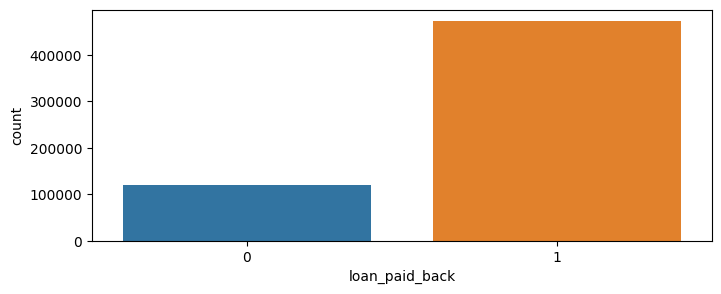

In [19]:
plt.figure(figsize = (8, 3))
sns.countplot(df_train, x = y)
plt.show()

In [20]:
df_train[X_cont].describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.207031,0.120696,680.916009,15020.297852,12.356345
std,26707.685547,0.068564,55.424956,6925.615723,2.008670
min,6002.430176,0.011000,395.000000,500.089996,3.200000
25%,27934.400391,0.072000,646.000000,10279.620117,10.990000
50%,46557.679688,0.096000,682.000000,15000.219727,12.370000
75%,60981.320312,0.156000,719.000000,18858.580078,13.680000
max,393381.750000,0.627000,849.000000,48959.949219,20.990000


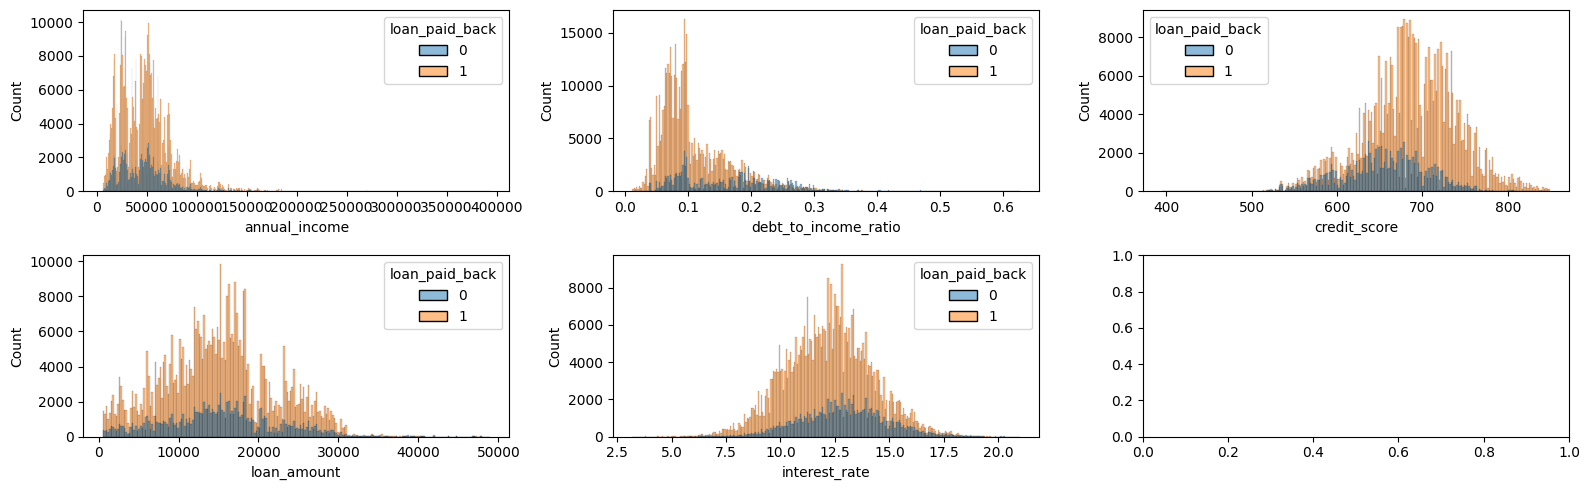

In [21]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x = i, hue = y, ax = ax)
plt.tight_layout()
plt.show()

In [22]:
df_corr = df_train[X_cont].corr()
df_corr

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
annual_income,1.000000,0.000553,0.001509,-0.003407,-0.002507
debt_to_income_ratio,0.000553,1.000000,-0.061617,-0.008236,0.030316
credit_score,0.001509,-0.061617,1.000000,-0.005761,-0.538335
loan_amount,-0.003407,-0.008236,-0.005761,1.000000,-0.001174
interest_rate,-0.002507,0.030316,-0.538335,-0.001174,1.000000


In [23]:
df_corr.reset_index().melt(id_vars = 'index').pipe(
    lambda x: x.loc[x['index'] < x['variable']]
).sort_values('value', ascending = False)

,index,variable,value
21,debt_to_income_ratio,interest_rate,0.030316
10,annual_income,credit_score,0.001509
5,annual_income,debt_to_income_ratio,0.000553
19,interest_rate,loan_amount,-0.001174
20,annual_income,interest_rate,-0.002507
15,annual_income,loan_amount,-0.003407
17,credit_score,loan_amount,-0.005761
16,debt_to_income_ratio,loan_amount,-0.008236
7,credit_score,debt_to_income_ratio,-0.061617
22,credit_score,interest_rate,-0.538335


In [24]:
from scipy.stats import f_oneway

pd.Series({
    i: f_oneway(*df_train.groupby(y)[i].agg(list)).pvalue
    for i in X_cont
}).sort_values().to_frame().T

,debt_to_income_ratio,credit_score,interest_rate,annual_income,loan_amount
0,0.0,0.0,0.0,0.000001,0.003737


In [25]:
roc_auc_score(
    df_train[y], -df_train['debt_to_income_ratio']
)

0.715270052169029

In [26]:
roc_auc_score(
    df_train[y], df_train['credit_score']
)

0.6711532058294982

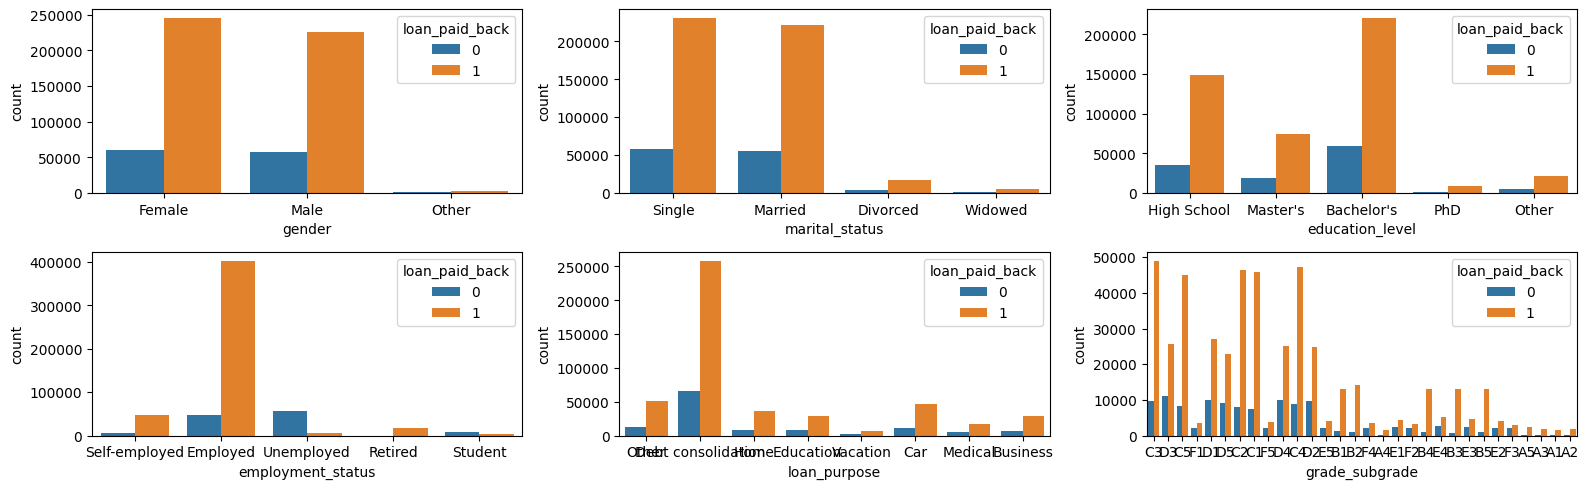

In [27]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
for i, ax in zip(X_cat, axes.flatten()):
    sns.countplot(df_train, x = i, hue = y, ax = ax)
plt.tight_layout()
plt.show()

In [28]:
from scipy.stats import chi2_contingency

pd.Series({
    i: chi2_contingency(
        pd.crosstab(
            index = df_train[y], columns = df_train[i]
        )
    )[1]
    for i in X_cat
}).sort_values().to_frame().T

,employment_status,grade_subgrade,education_level,loan_purpose,gender,marital_status
0,0.0,0.0,1.055186e-81,1.725854e-80,7.495415e-08,0.248564


In [29]:
from scipy.spatial.distance import pdist, squareform
pd.DataFrame(
    squareform(
        pdist(
            df_train[X_cat].T, 
            metric = lambda u, v: chi2_contingency(
                pd.crosstab(index = u, columns = v)
            )[1]
        )
    ), index = X_cat, columns = X_cat
).reset_index().melt(id_vars = 'index').pipe(
    lambda x: x.loc[x['index'] < x['variable']]
).sort_values('value', ascending = True)

,index,variable,value
33,employment_status,grade_subgrade,0.000000e+00
27,employment_status,loan_purpose,3.495173e-95
20,education_level,employment_status,1.508930e-70
32,education_level,grade_subgrade,1.823507e-54
26,education_level,loan_purpose,1.174815e-50
11,grade_subgrade,marital_status,8.373960e-39
10,loan_purpose,marital_status,2.127016e-33
8,education_level,marital_status,2.500353e-22
29,grade_subgrade,loan_purpose,5.555442e-21
9,employment_status,marital_status,1.392018e-12


In [30]:
df_anova = pd.DataFrame([
    (i, j, f_oneway(*df_train.groupby(j)[i].agg(list)).pvalue)
    for i, j in product(X_cont, X_cat)
], columns = ['cat', 'cont', 'pvalue'])
df_anova.sort_values('pvalue')

,cat,cont,pvalue
29,interest_rate,grade_subgrade,0.000000e+00
17,credit_score,grade_subgrade,0.000000e+00
15,credit_score,employment_status,0.000000e+00
9,debt_to_income_ratio,employment_status,0.000000e+00
11,debt_to_income_ratio,grade_subgrade,0.000000e+00
27,interest_rate,employment_status,1.232892e-307
10,debt_to_income_ratio,loan_purpose,1.163941e-29
23,loan_amount,grade_subgrade,2.851169e-19
16,credit_score,loan_purpose,1.132175e-16
13,credit_score,marital_status,1.696289e-14


In [18]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [32]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', 'passthrough', X_cont)
])

clf_dt = make_pipeline(
    ct, DecisionTreeClassifier(max_depth = 8)
)
clf_dt.fit(df_train_ho[X_all], df_train_ho[y])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade']),
                                                 ('pt', 'passthrough',
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8))])

In [33]:
(
    roc_auc_score(
        df_train_ho[y], clf_dt.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_dt.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9126415043324629, 0.9127372055638713)

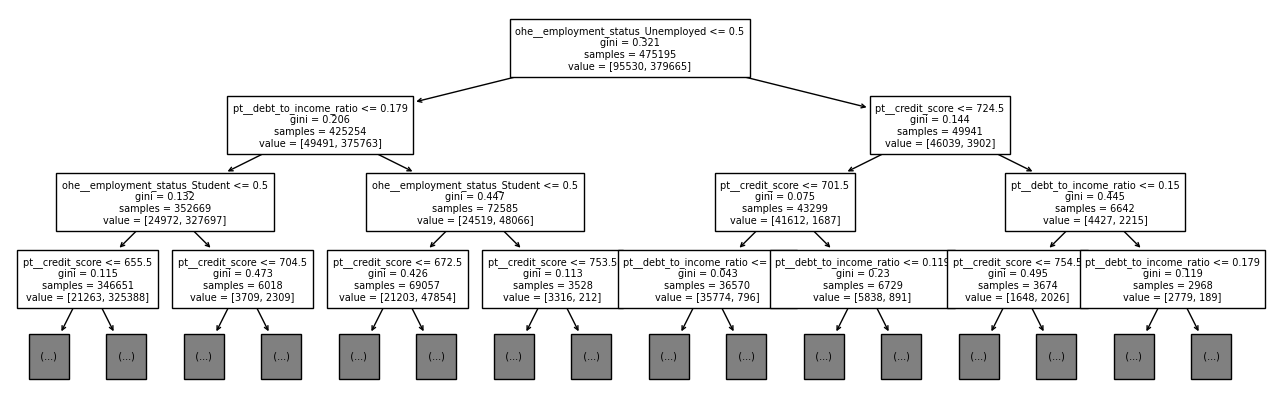

In [34]:
from sklearn.tree import plot_tree
plt.figure(figsize = (16, 5))
plot_tree(clf_dt[-1], feature_names = clf_dt[0].get_feature_names_out(), max_depth = 3, fontsize = 7)
plt.show()

In [37]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), X_cat),
    ('pt', StandardScaler(), X_cont)
])

clf_lr = make_pipeline(
    ct, LogisticRegression()
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade']),
                                                 ('pt', StandardScaler(),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate'])])),
                ('logisticregression', LogisticRegression())])

In [38]:
roc_auc_score(
    df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
)

0.9117097590321253

In [39]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['employment_status']),
    ('std', StandardScaler(), ['debt_to_income_ratio', 'credit_score'])
])

clf_lr = make_pipeline(
    ct, LogisticRegression()
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9097059895600774, 0.9108124263795155)

In [40]:
pd.Series(clf_lr[-1].coef_[0], index = clf_lr[0].get_feature_names_out())

ohe__employment_status_Retired          3.753355
ohe__employment_status_Self-employed    0.003912
ohe__employment_status_Student         -3.371583
ohe__employment_status_Unemployed      -4.992496
pt__debt_to_income_ratio               -0.858910
pt__credit_score                        0.801030
dtype: float64

In [31]:
from scipy.stats import zscore
roc_auc_score(
    df_test_ho[y], zscore(df_test_ho['credit_score']) - zscore(df_test_ho['debt_to_income_ratio'])
)

0.7724465104751075

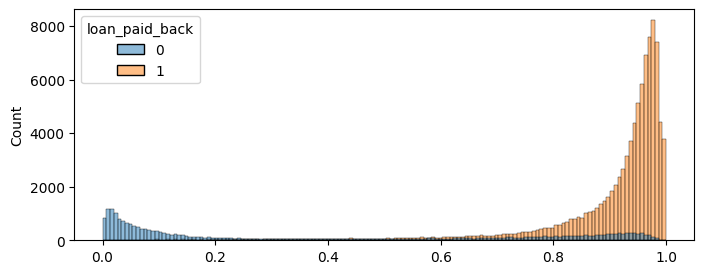

In [41]:
plt.figure(figsize = (8, 3))
sns.histplot(
    x = clf_lr.predict_proba(df_test_ho[X_all])[:, 1], hue = df_test_ho[y]
)
plt.show()

**employment_status** 가 가장 중요한 속성으로 보입니다.

In [42]:
s_ratio = df_train.groupby('employment_status').apply(lambda x: (x[y] == 1).mean(), include_groups=False)
s_ratio

employment_status
Self-employed    0.898457
Employed         0.894145
Unemployed       0.077619
Retired          0.997204
Student          0.263515
dtype: float64

In [43]:
df_train['employment_status'].value_counts()

employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64

In [44]:
(
    roc_auc_score(df_train_ho[y], df_train_ho['employment_status'].map(s_ratio)),
    roc_auc_score(df_test_ho[y], df_test_ho['employment_status'].map(s_ratio))
)

(0.7790427290101011, 0.7793472885935477)

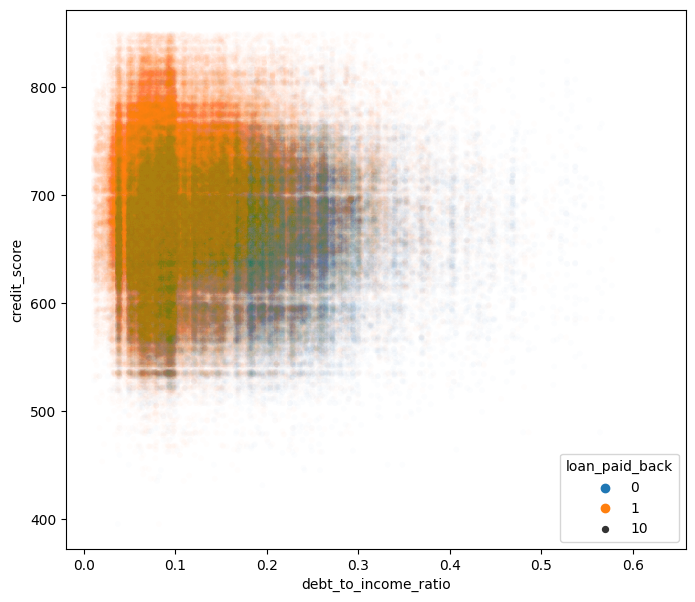

In [45]:
plt.figure(figsize = (8, 7))
sns.scatterplot(
    df_train, x = 'debt_to_income_ratio', y = 'credit_score', hue = y, size = 10, alpha = 0.01
)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x700 with 0 Axes>

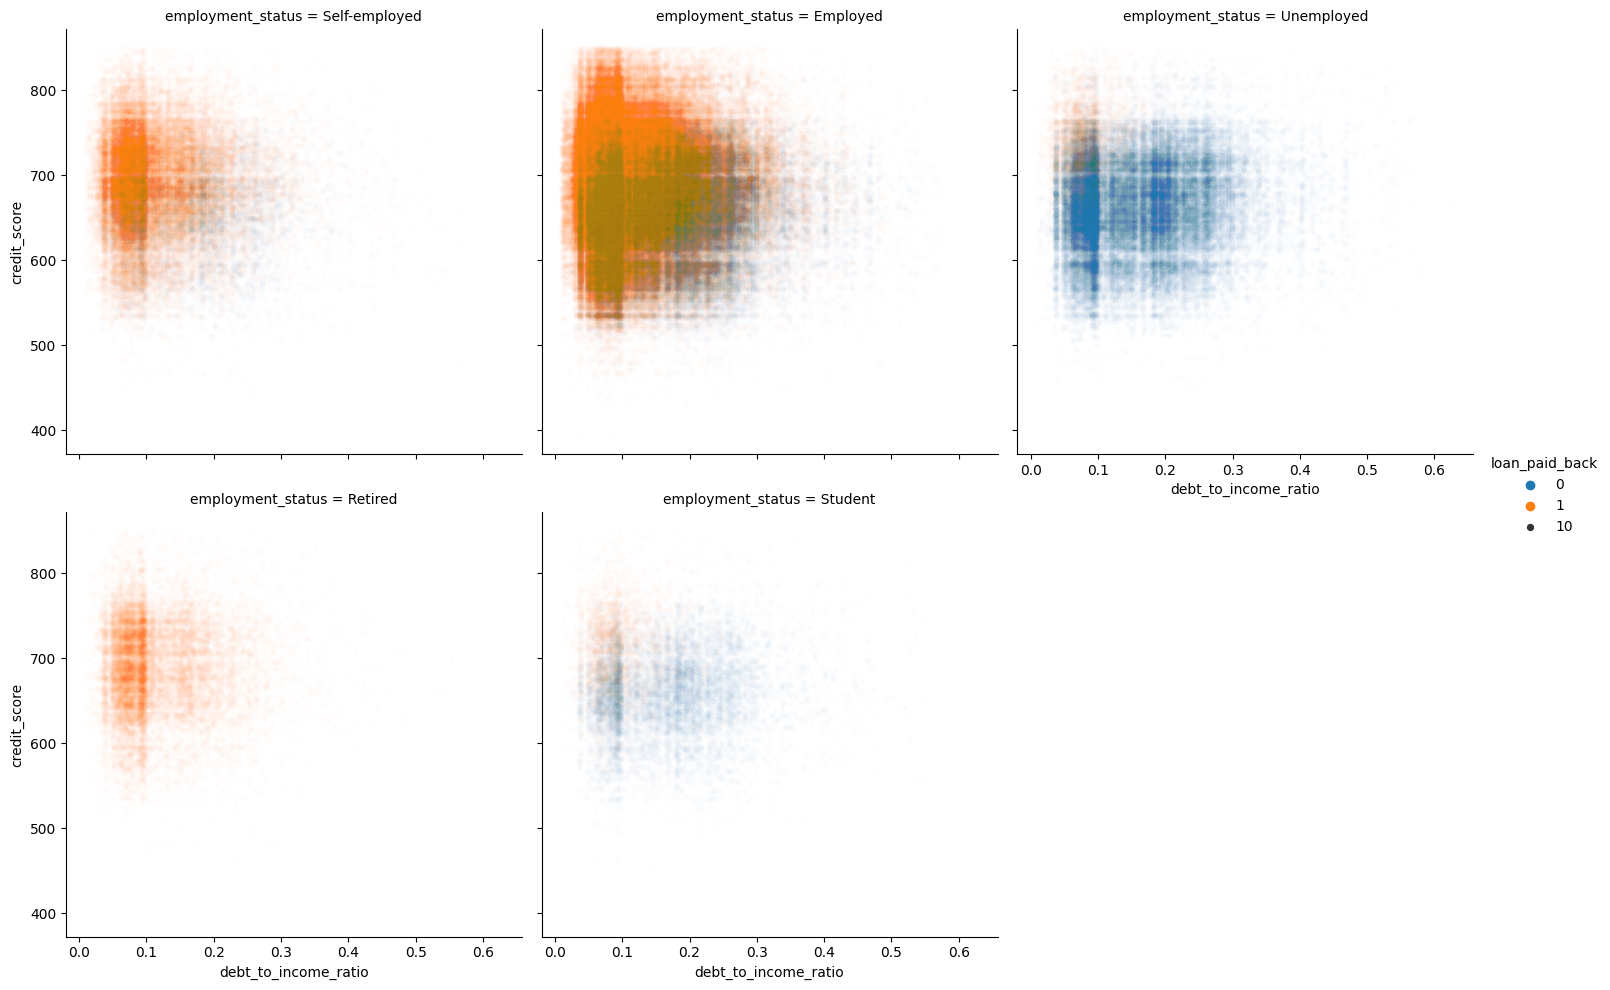

In [46]:
plt.figure(figsize = (8, 7))
sns.relplot(
    df_train, x = 'debt_to_income_ratio', y = 'credit_score', hue = y, col='employment_status', col_wrap = 3, size = 10, alpha = 0.01
)
plt.show()

The figure layout has changed to tight


<Figure size 800x700 with 0 Axes>

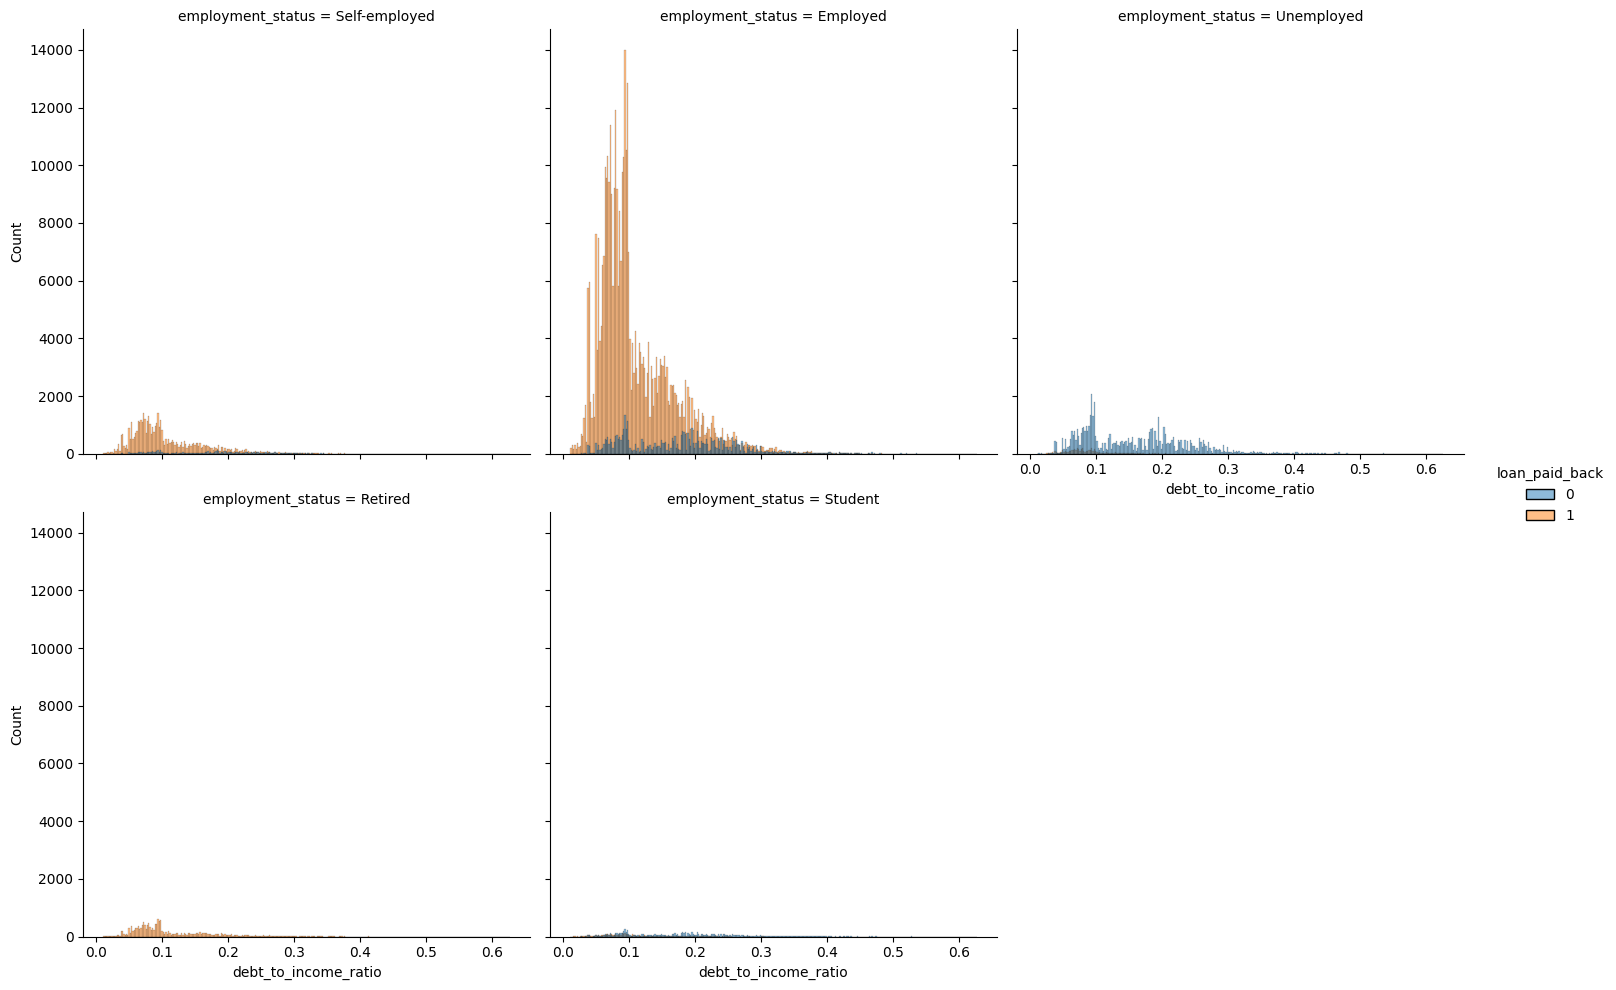

In [75]:
plt.figure(figsize = (8, 7))
sns.displot(
    df_train, x = 'debt_to_income_ratio', hue = y, col='employment_status', col_wrap = 3,
)
plt.show()

The figure layout has changed to tight


<Figure size 800x700 with 0 Axes>

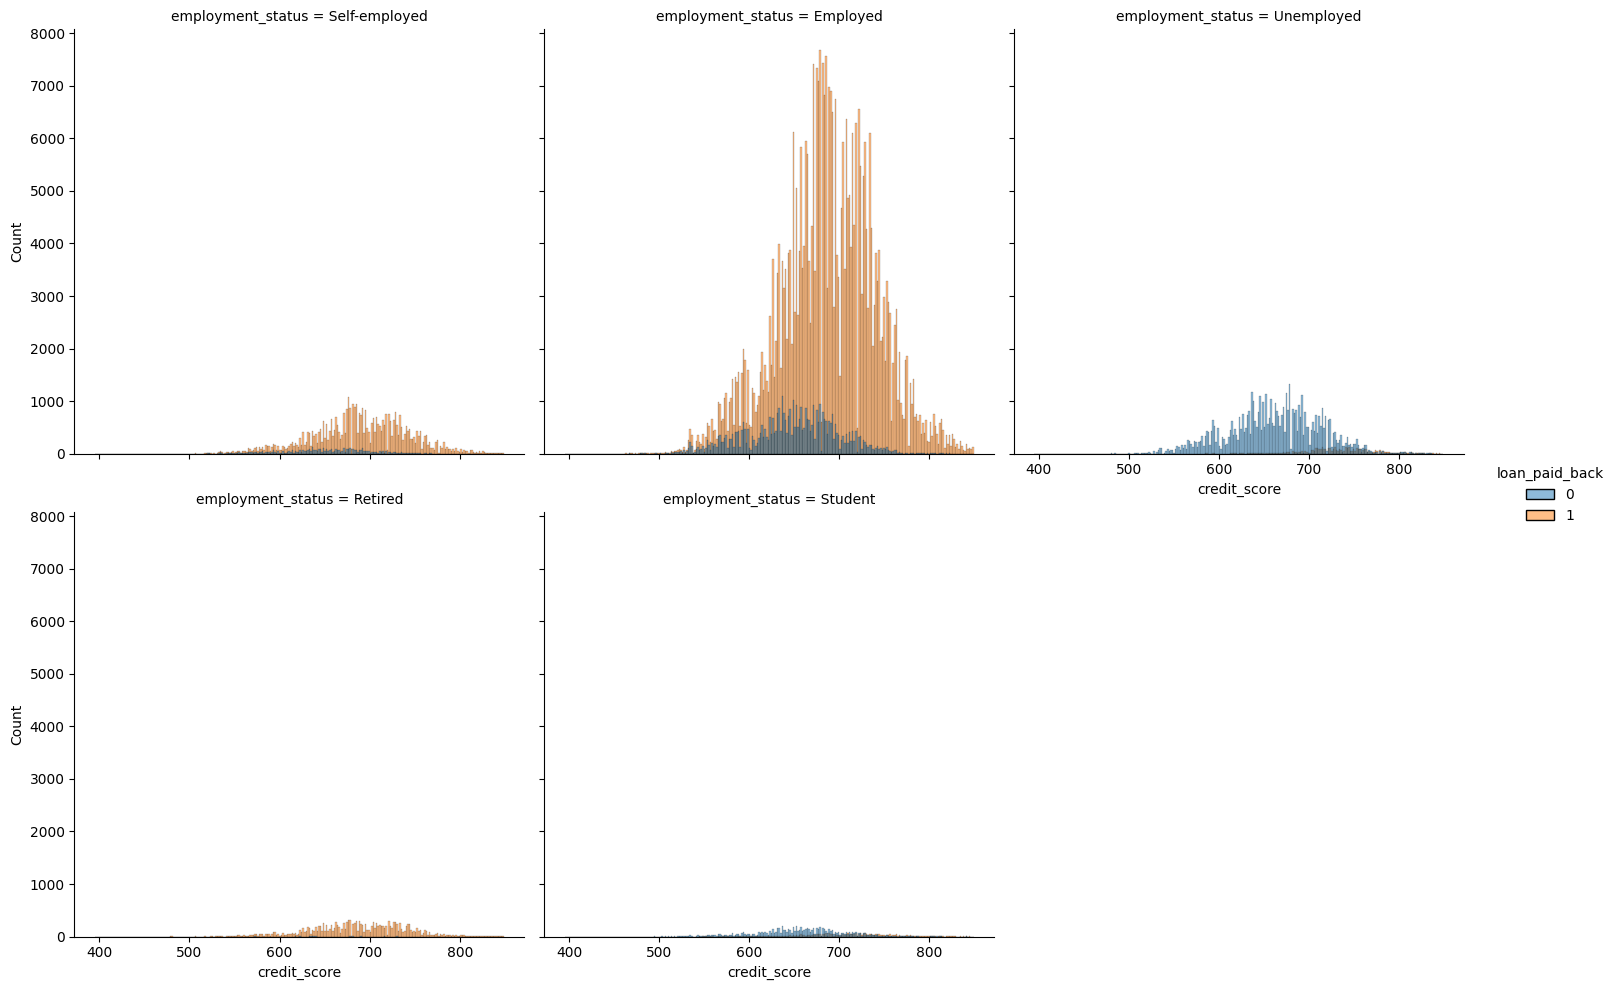

In [76]:
plt.figure(figsize = (8, 7))
sns.displot(
    df_train, x = 'credit_score', hue = y, col='employment_status', col_wrap = 3,
)
plt.show()

In [47]:
df_train[['debt_to_income_ratio', 'credit_score', 'employment_status']].value_counts()

debt_to_income_ratio  credit_score  employment_status
0.093                 672           Employed             110
0.090                 708           Employed             109
0.093                 708           Employed             106
0.097                 672           Employed             105
0.093                 669           Employed             101
                                                        ... 
0.139                 647           Retired                1
                                    Unemployed             1
                      646           Retired                1
                      645           Student                1
0.627                 667           Unemployed             1
Name: count, Length: 146932, dtype: int64

In [48]:
df_train.groupby(['debt_to_income_ratio', 'credit_score', 'employment_status']).filter(lambda x: len(x) >= 30).groupby(
    ['debt_to_income_ratio', 'credit_score', 'employment_status'], observed = True
)[y].agg(['mean', 'count']).sort_values('mean')

mean  count
debt_to_income_ratio credit_score employment_status                 
0.094                637          Employed           0.676471     34
0.097                637          Employed           0.687500     32
                     644          Employed           0.702703     37
0.093                646          Employed           0.704918     61
0.094                654          Employed           0.710526     38
...                                                       ...    ...
0.067                688          Employed           1.000000     34
0.076                688          Employed           1.000000     35
0.079                751          Employed           1.000000     48
0.091                726          Employed           1.000000     32
                     689          Employed           1.000000     46

[3067 rows x 2 columns]

In [49]:
s_ratio = df_train.groupby('grade_subgrade').apply(lambda x: (x[y] == 1).mean(), include_groups=False)
pd.concat([
    s_ratio.rename('ratio'), 
    df_train['grade_subgrade'].value_counts().rename('cnt')
], axis=1).sort_values('ratio')

,ratio,cnt
grade_subgrade,,
F3,0.604093,5082
F2,0.617721,5203
F1,0.624503,5534
F4,0.637037,5535
F5,0.639314,5947
E3,0.641837,7075
E4,0.649577,8036
E1,0.652010,6891
E2,0.662743,6372


In [50]:
(
    roc_auc_score(df_train_ho[y], df_train_ho['grade_subgrade'].map(s_ratio)),
    roc_auc_score(df_test_ho[y], df_test_ho['grade_subgrade'].map(s_ratio))
)

(0.6570200012104145, 0.658087256928532)

In [51]:
import xgboost as xgb
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', StandardScaler(), X_cont)
])
clf_xgb = xgb.XGBClassifier(
    tree_method = 'hist', device = 'cuda'
)
clf_xgb.fit(ct.fit_transform(df_train_ho[X_all]), df_train_ho[y])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
(
    roc_auc_score(
        df_train_ho[y], clf_xgb.predict_proba(ct.transform(df_train_ho[X_all]))[:,  1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_xgb.predict_proba(ct.transform(df_test_ho[X_all]))[:,  1]
    )
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:46:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


(0.9298523087953864, 0.9215336288981761)

In [53]:
explainer = shap.TreeExplainer(clf_xgb)

In [54]:
shap_interaction = explainer.shap_interaction_values(ct.transform(df_test_ho[X_all]))

In [56]:
df_intr = pd.DataFrame(
    np.abs(shap_interaction).mean(axis = 0), index = ct.get_feature_names_out(), columns = ct.get_feature_names_out()
)

In [57]:
df_intr.stack().rename('value').reset_index().pipe(
    lambda x: x.loc[x['level_0'] < x['level_1']]
).sort_values('value', ascending = False).iloc[:20]

,level_0,level_1,value
3476,pt__credit_score,pt__debt_to_income_ratio,0.084306
1017,ohe__employment_status_Unemployed,pt__credit_score,0.053405
1016,ohe__employment_status_Unemployed,pt__debt_to_income_ratio,0.029016
3356,pt__annual_income,pt__debt_to_income_ratio,0.025077
3418,pt__debt_to_income_ratio,pt__loan_amount,0.019984
3479,pt__credit_score,pt__interest_rate,0.019900
3357,pt__annual_income,pt__credit_score,0.016916
3419,pt__debt_to_income_ratio,pt__interest_rate,0.016278
3478,pt__credit_score,pt__loan_amount,0.016230
916,ohe__employment_status_Student,ohe__employment_status_Unemployed,0.015474


In [58]:
clf_lgb = lgb.LGBMClassifier(verbose = -1, categorical_features = X_cat)
clf_lgb.fit(df_train_ho[X_all], df_train_ho[y])

categorical_features in param dict is overridden.


LGBMClassifier(categorical_features=['gender', 'marital_status',
                                     'education_level', 'employment_status',
                                     'loan_purpose', 'grade_subgrade'],
               verbose=-1)

In [59]:
(
    roc_auc_score(
        df_train_ho[y], clf_lgb.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lgb.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9219875314746923, 0.9206961774326652)

In [60]:
clf_lgb = make_pipeline(ct, lgb.LGBMClassifier(verbose = -1))
clf_lgb.fit(df_train_ho[X_all], df_train_ho[y])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade']),
                                                 ('pt', StandardScaler(),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate'])])),
                ('lgbmclassifier', LGBMClassifier(verbose=-1))])

In [61]:
(
    roc_auc_score(
        df_train_ho[y], clf_lgb.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lgb.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.921712939443939, 0.9209514160818724)

In [63]:
clf_cb = cb.CatBoostClassifier(
    cat_features = X_cat, verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_all], df_train_ho[y])

In [64]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9278674650548959, 0.9236015025319736)

In [7]:
c_map = {
    c: i
    for i, c in enumerate(np.sort(df_train['grade_subgrade'].unique()))
}
df_train['grade_subgrade_no'] = df_train['grade_subgrade'].map(c_map).astype(np.int16)
df_test['grade_subgrade_no'] = df_test['grade_subgrade'].map(c_map).astype(np.int16)

In [9]:
with open('grade_subgrade.pkl', 'wb') as f:
    pkl.dump(c_map, f)

In [66]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [67]:
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i != 'grade_subgrade'], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[[i for i in X_all if i != 'grade_subgrade'] + ['grade_subgrade_no']], df_train_ho[y])

In [68]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no']])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no']])[:, 1]
    )
)

(0.9285954762394324, 0.9237379424896613)

In [69]:
df_train['debt'] = df_train['debt_to_income_ratio'] * df_train['annual_income']

In [70]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [71]:
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i != 'grade_subgrade'], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[[i for i in X_all if i != 'grade_subgrade'] + ['grade_subgrade_no', 'debt']], df_train_ho[y])

In [72]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no', 'debt']])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no', 'debt']])[:, 1]
    )
)

(0.9286552247644245, 0.9236281178593638)